# Time Series Analysis with Parameter Optimization
  ARIMA and Exponential Smoothing modeling with parameter optimization.

In [14]:

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')


In [15]:

# Load data
df = pd.read_csv("exchange_rate.csv", header=0)

df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce') #date type convertion
df['date'].min(), df['date'].max()



(Timestamp('1990-01-01 00:00:00'), Timestamp('2010-10-10 00:00:00'))

In [16]:
df = df.sort_values('date')
df = df.groupby('date')['Ex_rate'].sum().reset_index()
df = df.set_index('date') #set index by date 
y = df['Ex_rate'].resample("M").mean()

In [ ]:

# Split for and train and test
train = y.loc[:"2003-12-31"]
test = y.loc['2004-1-31':]


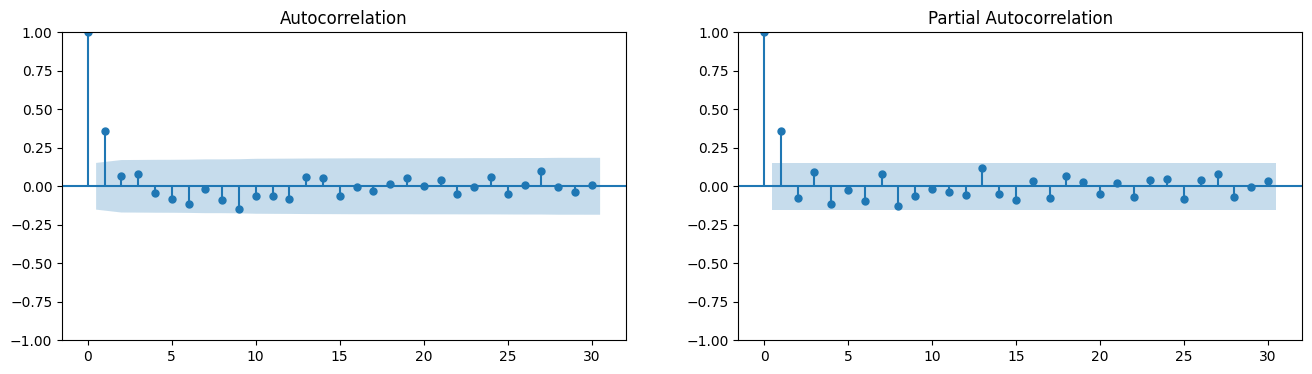

In [18]:

# Ploting ACF and PACF for ARIMA parameter estimation
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(train.diff().dropna(), lags=30, ax=axes[0])
plot_pacf(train.diff().dropna(), lags=30, ax=axes[1])
plt.show()


## ARIMA Model with Parameter Optimization using AIC

In [19]:

# Grid search for ARIMA parameters
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_order = None
best_model = None

for order in pdq:
    try:
        model = ARIMA(train, order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
    except:
        continue

print(f"Best ARIMA order: {best_order}, AIC: {best_aic:.2f}")
best_model.summary()


Best ARIMA order: (1, 0, 1), AIC: -789.56


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                  168
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 398.780
Date:                Thu, 16 Oct 2025   AIC                           -789.560
Time:                        19:08:37   BIC                           -777.064
Sample:                    01-31-1990   HQIC                          -784.488
                         - 12-31-2003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7425      0.057     12.989      0.000       0.630       0.855
ar.L1          0.9533      0.024     40.403      0.000       0.907       1.000
ma.L1          0.4301      0.054      7.932      0.000       0.324       0.536
sigma2         0.0005   4.09e-05     12.159      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                79.65
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               4.32   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

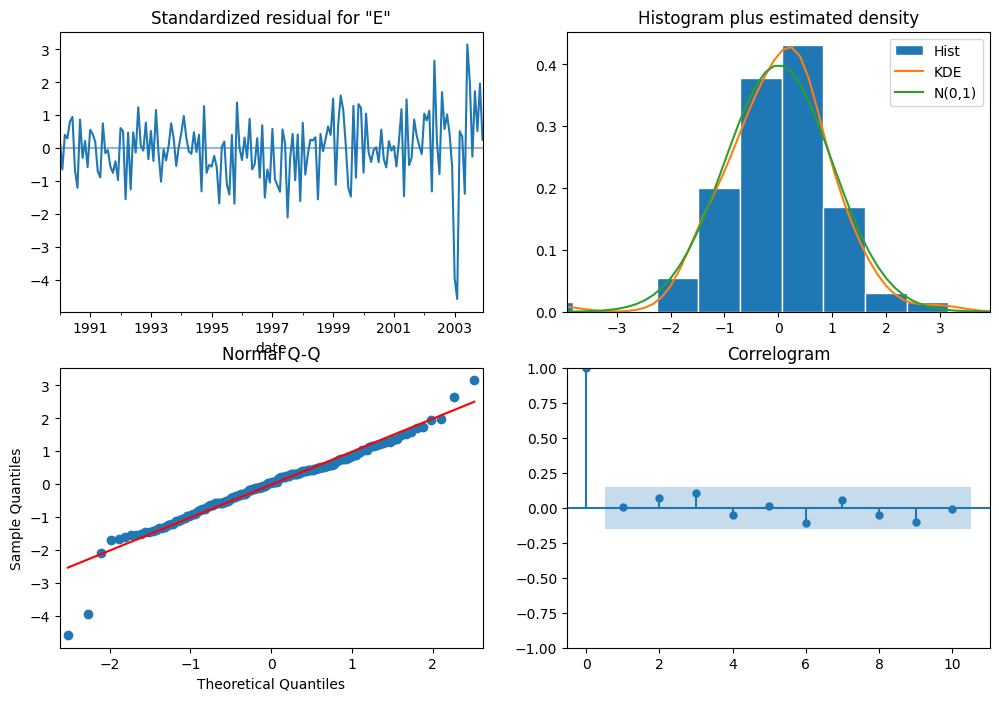

In [20]:


# Diagnostics
best_model.plot_diagnostics(figsize=(12, 8))
plt.show()


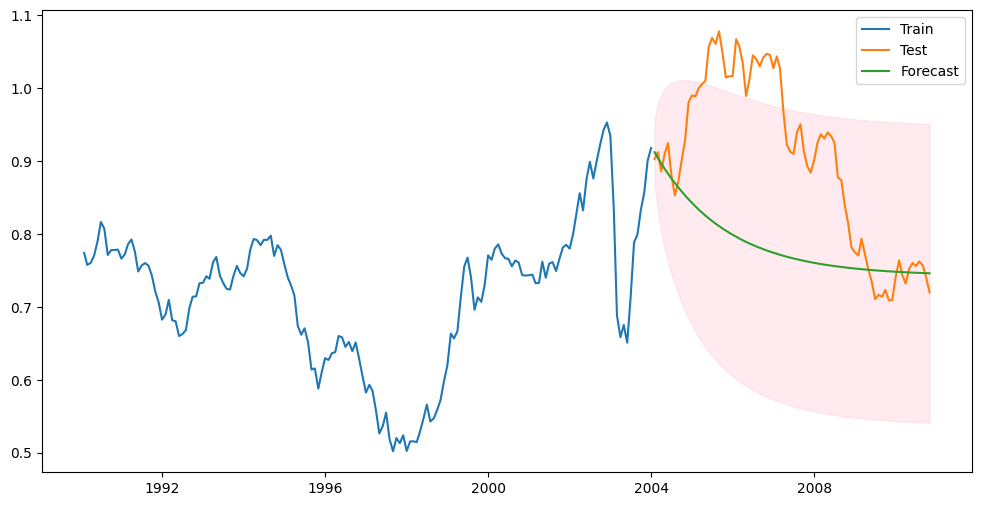

In [21]:

# Forecasting
n_forecast = len(test)
forecast = best_model.get_forecast(steps=n_forecast)
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label="Forecast")
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='pink', alpha=0.3)
plt.legend()
plt.show()


## Exponential Smoothing with Parameter Optimization

Best alpha: 0.61, RMSE: 0.12


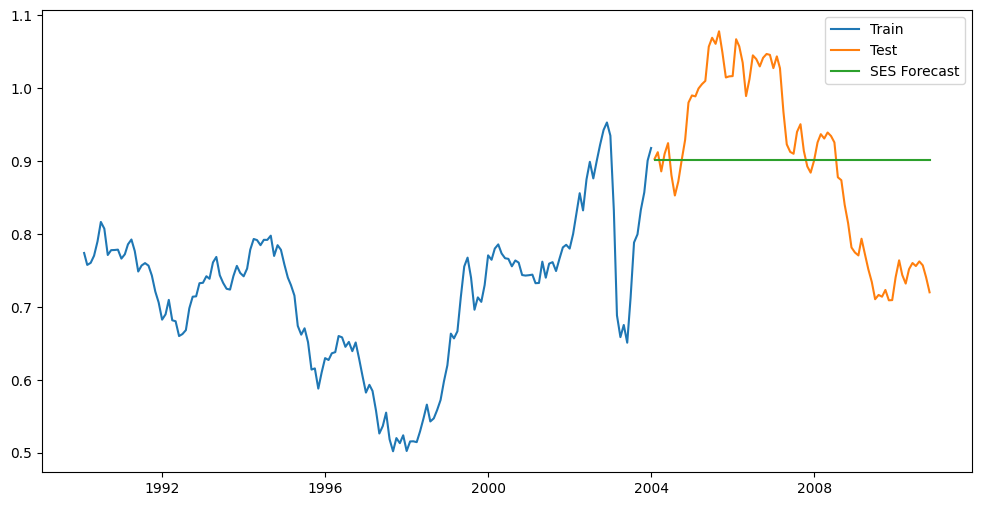

In [27]:

# Simple Exponential Smoothing with grid search for smoothing_level
best_rmse = np.inf #positive infinity 
best_alpha = None
best_ses_model = None

for alpha in np.arange(0.01, 1.0, 0.05):
    model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
    pred = model.forecast(len(test))
    rmse = sqrt(mean_squared_error(test, pred))
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha
        best_ses_model = model

print(f"Best alpha: {best_alpha}, RMSE: {best_rmse:.2f}")
pred = best_ses_model.forecast(len(test))

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='SES Forecast')
plt.legend()
plt.show()


Best Holt params (alpha, beta): (np.float64(0.01), np.float64(0.46)), RMSE: 0.09


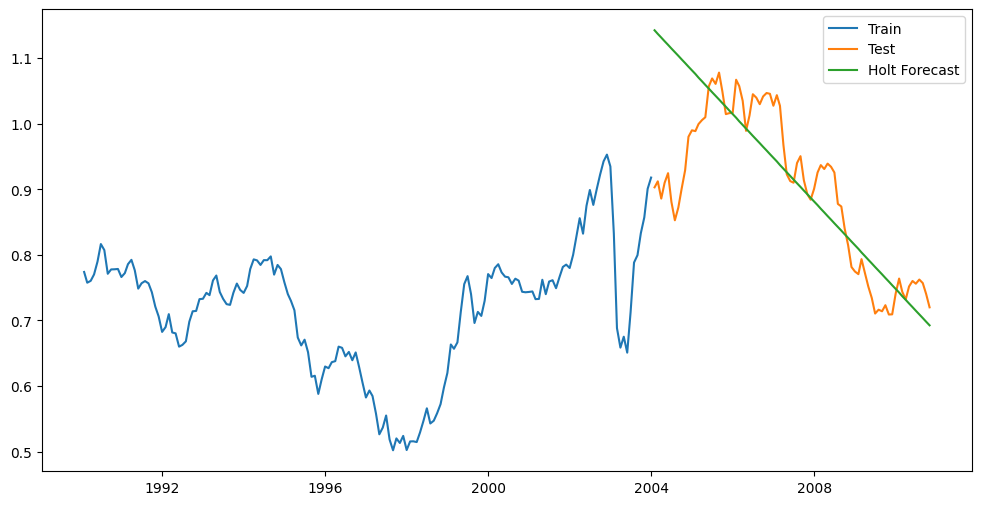

In [28]:

# Holt Linear with parameter optimization
best_rmse = np.inf
best_params = None
best_holt_model = None

for alpha in np.arange(0.01, 1.0, 0.05):
    for beta in np.arange(0.01, 1.0, 0.05):
        model = Holt(train).fit(smoothing_level=alpha, smoothing_slope=beta, optimized=False)
        pred = model.forecast(len(test))
        rmse = sqrt(mean_squared_error(test, pred))
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (alpha, beta)
            best_holt_model = model

print(f"Best Holt params (alpha, beta): {best_params}, RMSE: {best_rmse:.2f}")
pred = best_holt_model.forecast(len(test))

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt Forecast')
plt.legend()
plt.show()


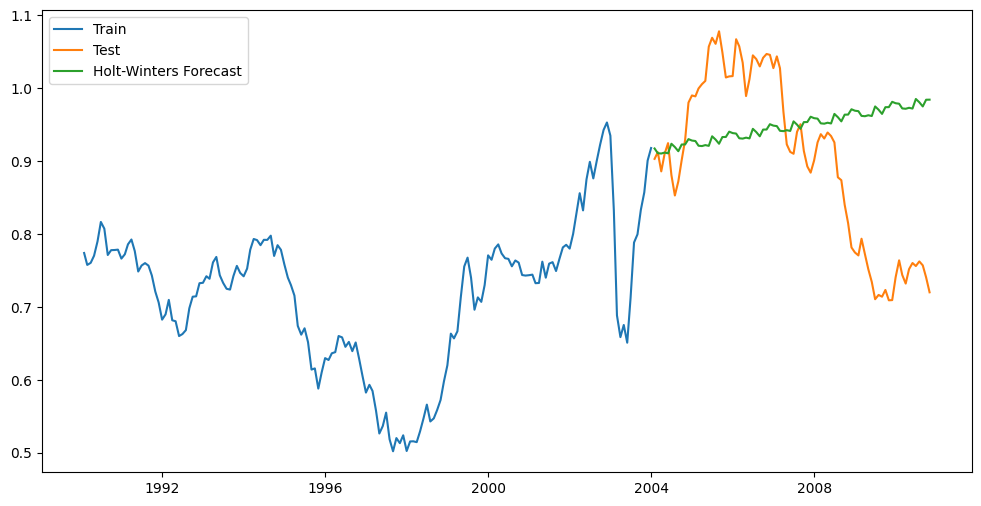

In [31]:

# Holt-Winters with additive trend and seasonality, optimized automatically
hw_model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add').fit(optimized=True)
hw_forecast = hw_model.forecast(len(test))

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast')
plt.legend()
plt.show()


## Conclusion
- ARIMA: Selected using grid search and AIC for best parameters.
- Exponential Smoothing: Simple, Holt, and Holt-Winters models optimized for best RMSE.
- Forecasts compared with test data for evaluation.
- Parameter optimization improves model accuracy and reliability.